# iMet Collection 2020 Kaggle Competition
Create a model that can assign attributes to artwork from Metropolitan Meuseum of Art.

Created by: Arnav Malhotra using fastai 

I followed the general transfer learning example laid out in lesson 3 of the [fastai-v3 course](course.fast.ai)

The main aim of this project is to get more familar with Kaggle submissions and the `data_block` API

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('data/'); path

WindowsPath('data')

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,attribute_ids
0,000040d66f14ced4cdd18cd95d91800f,448 2429 782
1,0000ef13e37ef70412166725ec034a8a,2997 3231 2730 3294 3099 2017 784
2,0001eeb4a06e8daa7c6951bcd124c3c7,2436 1715 23
3,000226398d224de78b191e6db45fd94e,2997 3433 448 782
4,00029c3b0171158d63b1bbf803a7d750,3465 3322 3170 1553 781


In [5]:
df_labels = pd.read_csv(path/'labels.csv')
df_labels.head()
#df_labels.loc[1,'attribute_name']
label_func = lambda attr_id: df_labels.loc[attr_id, 'attribute_name']

Todo:

Why these transforms?

In [6]:
tfms = get_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='train', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' ')
      .add_test_folder())

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

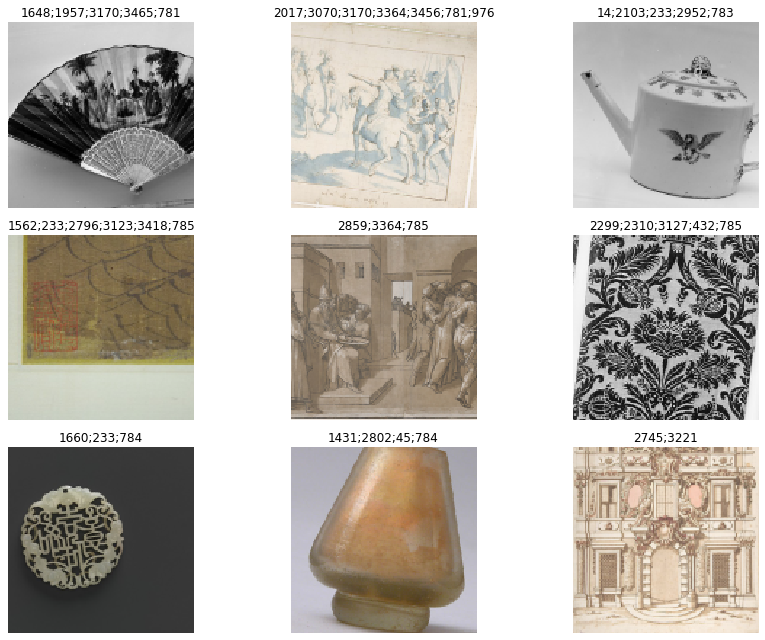

In [9]:
data.show_batch(rows=3, figsize=(12,9))

# Creating and Training Model
Using resnet50 as base architecture

In [9]:
arch = models.resnet50

In [10]:
# defining error metrics
acc_02 = partial(accuracy_thresh, thresh=0.2) # defining new metrics to report (needs to be a function)
f_score = partial(fbeta, thresh=0.2) # ''

In [11]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


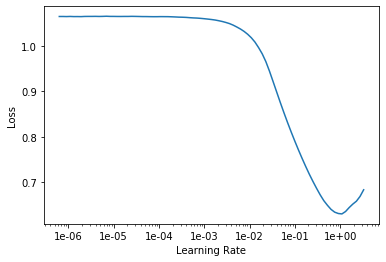

In [18]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 1e-1

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.011797,2.323402,0.995706,0.237820,22:48
1,0.007908,1.958848,0.998371,0.104645,22:53
2,0.006548,5.299791,0.997133,0.209883,22:58
3,0.005605,0.031219,0.998227,0.322930,1:31:11
4,0.005218,0.430090,0.997539,0.327444,24:31


Fine-Tuning

In [15]:
learn.save('stage-1')

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


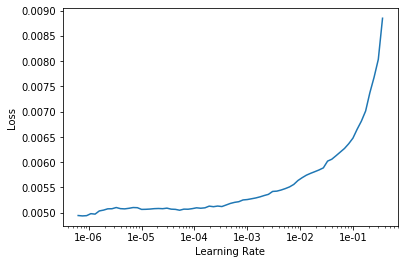

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.005354,0.731384,0.996721,0.326572,25:16
1,0.005270,0.443391,0.995867,0.323745,22:42
2,0.004920,0.765373,0.991968,0.361545,22:44
3,0.004588,1.644236,0.990556,0.399999,22:43
4,0.004484,0.846041,0.991632,0.432203,22:51


In [20]:
learn.save('stage-2')

# Transfer Learning

Here we use a larger image size to train again. I want to experiment with image sizes here to see what the effects are, my prediction is that I'll just have to keep reducing the batch size and it won't have too much of an effect.

Note: before this stage, fbeta in last epoch was 0.432

In [12]:
learn.load('stage-2')
data = (src.transform(tfms, size=256)
       .databunch(bs=32).normalize(imagenet_stats)) # I had to decrease batch size because I ran out of memory
learn.data = data

In [13]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


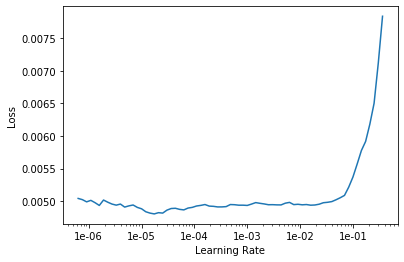

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
lr=1e-2

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.004861,3.743914,0.982370,0.351550,26:17
1,0.004977,0.939235,0.986424,0.317773,26:37
2,0.004778,0.617126,0.988956,0.386318,27:57
3,0.004629,2.744516,0.986317,0.422299,26:24
4,0.004563,0.753739,0.992272,0.419467,26:24


In [18]:
learn.save('stage-3-256')
# fbeta of last epoch for img_size=256: 0.412

In [19]:
learn.load('stage-4-256')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


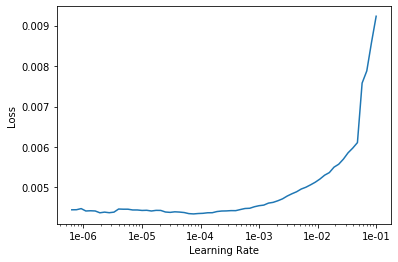

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.004574,2.401034,0.983602,0.410065,27:50
1,0.004511,0.650442,0.988177,0.421344,26:15
2,0.004424,0.454872,0.993530,0.441610,37:02
3,0.004328,1.189274,0.988371,0.448644,27:45
4,0.004351,1.428898,0.986663,0.435338,7:48:07


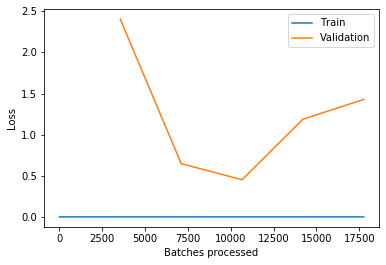

In [22]:
learn.save('stage-4-256')
learn.recorder.plot_losses()

# Creating submission file

In [ ]:
pred_class, pred_idx, outputs = learn.predict(is_test=True)
print(pred_class, pred_idx, outputs)
# try setting threshold to 0.1